In [1]:
import torch
import numpy as np
import os
import easydict
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

import ESGNN.backend.backend_torch_simu as backend_torch_simu
from ESGNN.utility.graph_cls_data_proc import load_dataset
from ESGNN.models.graph_cls_model import GraphClsESGNN
from ESGNN.utility.utils import split_wrt_masks
from DMD.dmd import KANN

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
options = easydict.EasyDict({
    "device": 'cuda',
    "dataset": 'mutag',
    "dim_hidden": 50,
    "wi_scaling": 0.0016,
    "wh_scaling": 0.006,
    "n_bit": 20,
    "lambdas": 1e-3,
    "leaky": 0.2,
    "n_iter": 10,
    "is_plt": False,
    "simulation": True,
    "noise": 0.02,
    "save_fmt": 'pdf'
})
dataset = options.dataset
if options.simulation:
    options.data_root_wh = f'./ESGNN/weights/{dataset}_selected_4b/wh'
    options.data_root_wi = f'./ESGNN/weights/{dataset}_selected_4b/wi'
elif dataset == 'collab':
    options.data_root_wh = f'./ESGNN/weights/{dataset}_selected_4b/wh/pos'
    options.data_root_wi = f'./ESGNN/weights/{dataset}_selected_4b/wi/pos'
elif dataset == 'mutag':
    options.data_root_wh = f'./ESGNN/weights/{dataset}_selected_4b/wh/neg'
    options.data_root_wi = f'./ESGNN/weights/{dataset}_selected_4b/wi/neg'


if options.dataset == 'collab':
    size_limit = 200
else:
    size_limit = 0
print(options)

# Torch setting
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
device = torch.device(options.device if torch.cuda.is_available() else 'cpu')
torch.device(device)

# Datasets
dim_input, avg_node_per_graph, adj_mats, node_labels, target, tr_samples, test_samples, nested_trs, nested_vals, idx = \
    load_dataset(options.dataset, sparse=False, size_limit=(200 if options.dataset == 'collab' else 0), device=device)

if options.dataset == 'mutag':
    num_class = 2
elif options.dataset == 'collab':
    num_class = 3
num_sample = len(adj_mats)
dataset_info = (adj_mats, node_labels, target)
idx = list(range(num_sample))

if options.simulation:
    WeightMultiplication = backend_torch_simu.WeightMultiplication_torch
# else:
    # For in-memory computing using hardware-implemented random weight matrices (via pynq.dma to command the Xilinx FPGA)
    # WeightMultiplication = WeightMultiplication

{'device': 'cuda', 'dataset': 'mutag', 'dim_hidden': 50, 'wi_scaling': 0.0016, 'wh_scaling': 0.006, 'n_bit': 20, 'lambdas': 0.001, 'leaky': 0.2, 'n_iter': 10, 'is_plt': False, 'simulation': True, 'noise': 0.02, 'save_fmt': 'pdf', 'data_root_wh': './ESGNN/weights/mutag_selected_4b/wh', 'data_root_wi': './ESGNN/weights/mutag_selected_4b/wi'}


In [3]:
def create_and_train_esn(options,
                         dataset_info,
                         state_init='gaussian',
                         init_ratio=0):
    # Load dataset
    adj_mats, node_labels, target = dataset_info

    # Wi_Wh multiplication backend
    backend_torch = WeightMultiplication(dim_input=dim_input,
                                         dim_hidden=options.dim_hidden,
                                         wi_scaling=options.wi_scaling,
                                         wh_scaling=options.wh_scaling,
                                         avg_node_per_graph=avg_node_per_graph,
                                         n_bit=options.n_bit,
                                         noise=options.noise,
                                         gen_weights=True,
                                         device=device)

    # Model
    model = GraphClsESGNN(dim_hidden=options.dim_hidden,
                        n_iter=options.n_iter,
                        leaky=options.leaky,
                        lambdas=options.lambdas,
                        bias=1,
                        backend=backend_torch,
                        store=True)
    model.to(device)

    model.backend = backend_torch

    # embeddings_b: [hid_dim + 1, num_graph]
    embeddings_b = model.batch_embed(
        node_labels, adj_mats, target, idx, rand_state_init=state_init, rand_init_ratio=init_ratio)

    # Random division train/test sets
    train_accs = []
    test_accs = []

    tr_embeddings = []

    for i in range(len(tr_samples)):

        # Train/Test partition for cross validation
        tr_embeddings_b, te_embeddings_b, tr_targets, te_targets = split_wrt_masks(
            tr_samples[i], test_samples[i], embeddings_b, target)
        
        tr_embeddings.append(tr_embeddings_b)

        # Train
        train_output = model.train_only(tr_embeddings_b, tr_targets)
        train_acc = torch.sum(
            tr_targets == train_output.sign()) / tr_targets.shape[-1]
        if options.dataset == 'collab':
            train_acc = torch.sum(torch.argmax(train_output, 0) == torch.argmax(
                tr_targets, 0)) / tr_targets.shape[-1]

        # Test
        te_output = model.test_only(te_embeddings_b)
        te_acc = torch.sum(torch.sign(te_output) ==
                           te_targets) / te_targets.shape[-1]

        # Adjust collab label to non-one-hot type
        if options.dataset == 'collab':
            te_acc = torch.sum(torch.argmax(te_output, dim=0) == torch.argmax(
                te_targets, dim=0)) / te_targets.shape[-1]
            te_targets = torch.argmax(te_targets, dim=0)
            te_output = torch.argmax(te_output, dim=0)
            tr_targets = torch.argmax(tr_targets, dim=0)
            train_output = torch.argmax(train_output, dim=0)

        train_accs.append(train_acc.cpu().numpy())
        test_accs.append(te_acc.cpu().numpy())

    return test_accs, train_accs, tr_embeddings, model

In [4]:
test_accs, train_accs, embeddings, model = create_and_train_esn(
        options, dataset_info, state_init='gaussian', init_ratio=0)
test_acc_list = [acc.item() for acc in test_accs]
print(f'fold-wis accuracy: {test_acc_list}')
print(f'10-fold avearge test accuracy: {np.mean(test_accs) * 100:.2f}%')

fold-wis accuracy: [0.9473684210526315, 0.9473684210526315, 0.894736842105263, 1.0, 0.8421052631578947, 0.894736842105263, 0.8421052631578947, 0.894736842105263, 0.8421052631578947, 1.0]
10-fold avearge test accuracy: 91.05%


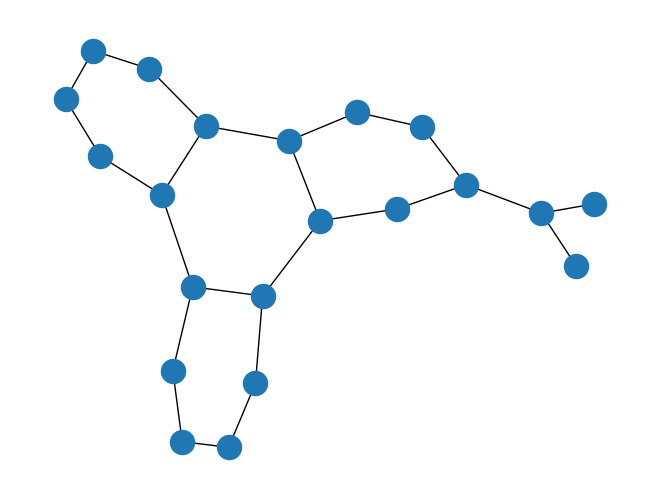

In [44]:
graph = 2 # graph index

edge_index = adj_mats[-graph].to_sparse().indices().cpu()
x = node_labels[-graph].cpu()
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [45]:
target[-graph] # target output

1

In [46]:
model.states[-graph].shape

torch.Size([50, 16])

In [47]:
H = torch.stack(model.states[-graph*options.n_iter:-(graph-1)*options.n_iter])
H = torch.cat([H[:,:,k] for k in range(H.shape[-1])], dim=-1)
H = H.unsqueeze(dim=0)

In [48]:
H.shape

torch.Size([1, 10, 1050])

- perform SVD on states H
- you get new states Zp with smaller dimensions
- find Koopman operator C that approximates Zp dynamics

In [49]:
# compute Koopman operator
kann_ = KANN(H.cpu(), emb="TruncatedSVD")
C = kann_.compute_KOP()
D, V = np.linalg.eig(C)
U = np.linalg.inv(V)

In [50]:
np.allclose(C,(V @ np.diag(D) @ U)) # returns True as expected

True

In [ ]:
# Q: What's the difference between this and what has ben done above?
# A: Matrix C is already squared because states H were already transformed with SVD
# so diagonalisation or SVD lead to the same results
Un, S, Vh = np.linalg.svd(C)

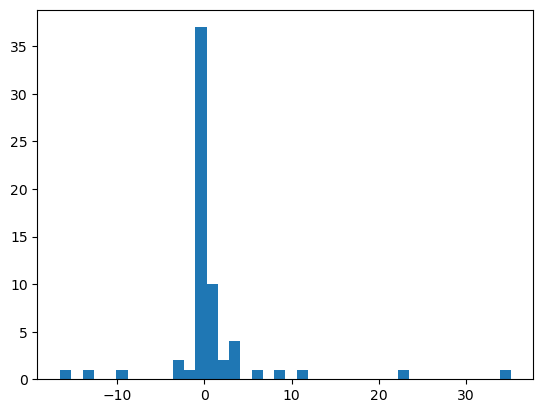

In [51]:
fig, ax = plt.subplots()
# the histogram of the data
n, bins, patches = ax.hist(C.flatten(), 40, density=False)

plt.show() 

In [52]:
(C>0.01).sum()

30

Plot Zp states:
- only the first one seems relevant

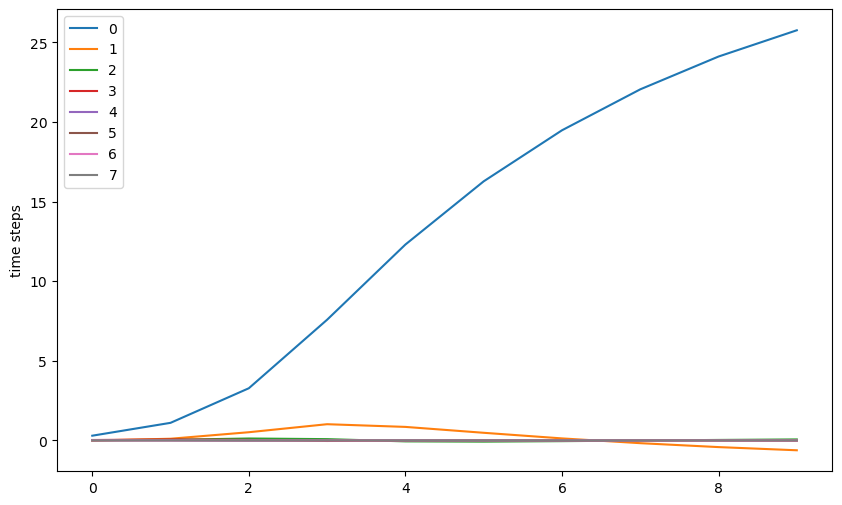

In [53]:
plt.figure(figsize=(10,6))
t = [i for i in range(H.shape[1])]
for n in range(kann_.Zp.shape[-1]):
    plt.plot(t, kann_.Zp.squeeze()[:,n], label=f'{n}')
# plt.yscale('log')
plt.ylabel('time steps')
plt.legend()
plt.show() 

- the first eigenvalue is the biggest
- it's close to 1, so the exponential dynamics doesn't kill it

In [54]:
D

array([ 1.0062362 +0.j        ,  0.71827263+0.06021385j,
        0.71827263-0.06021385j,  0.3022463 +0.30448632j,
        0.3022463 -0.30448632j, -0.08732757+0.2978384j ,
       -0.08732757-0.2978384j , -0.27858445+0.j        ])

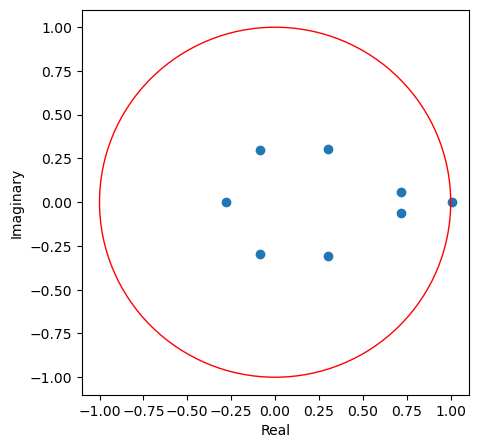

In [55]:
plt.figure(figsize=(5,5))
plt.scatter(D.real, D.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

Let's approximate Zp dynamics with C

In [56]:
first_Z = kann_.Zp.squeeze()[0,:]
newZp = np.stack([C**n @ first_Z for n in range(options.n_iter)])[np.newaxis,:,:]

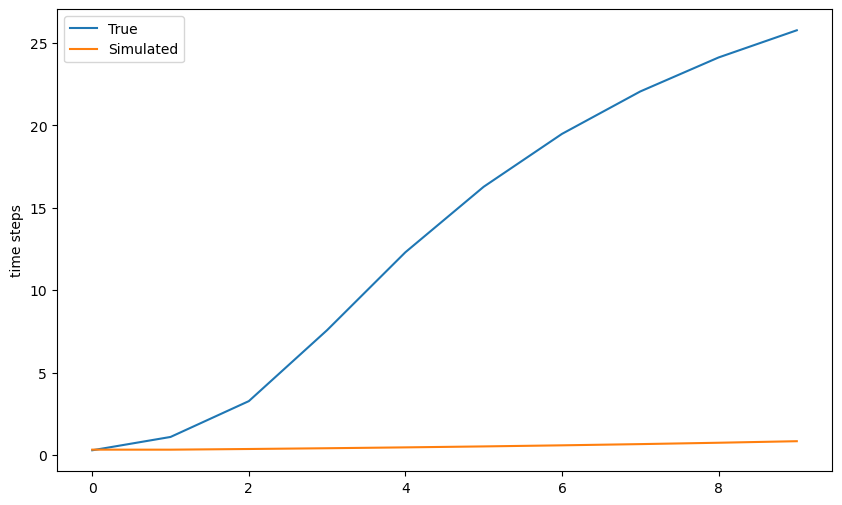

In [57]:
# plot the first one to check

plt.figure(figsize=(10,6))
t = [i for i in range(H.shape[1])]
plt.plot(t, kann_.Zp.squeeze()[:,0], label='True')
plt.plot(t, newZp.squeeze()[:,0], label='Simulated')
# plt.yscale('log')
plt.ylabel('time steps')
plt.legend()
plt.show() 

They are very different

Let's project states newZp onto the most important eignvector

In [58]:
np.absolute(D)

array([1.0062362 , 0.72079212, 0.72079212, 0.42902767, 0.42902767,
       0.31037689, 0.31037689, 0.27858445])

In [59]:
V[:,0].shape

(8,)

In [60]:
scal = V[:,0].T @ newZp.squeeze().T # scalar product with eigenvector
proj = np.stack([V[:,0]*s for s in scal]) # projection on eigenvector
proj = proj[np.newaxis, :, :] # add batch dim

In [61]:
proj.real.shape

(1, 10, 8)

Then we can recover the original sequence of states

In [62]:
recov = kann_.recover_states(proj.real, kann_.k)

In [63]:
# recover the right shape
new_states = np.stack([recov.squeeze()[:,k*options.dim_hidden:(k+1)*options.dim_hidden] for k in range(recov.shape[-1]//options.dim_hidden)], axis=-1)
new_states = torch.tensor(new_states)
# add bias, for reasons...
final_state_w_bias = torch.cat((new_states[-1,:,:], model.bias * torch.ones(1, new_states[-1,:,:].shape[1], device=model.device)), dim=0)

In [64]:
# send it through the model
model.test_only(final_state_w_bias)

tensor([[-8.8677e+13, -8.6985e+13, -6.5358e+13, -8.0969e+13, -8.0395e+13,
         -6.5702e+13, -7.8691e+13, -6.7746e+13, -8.7596e+13, -8.6922e+13,
         -6.8813e+13, -7.9994e+13, -8.2263e+13, -7.9814e+13, -5.7326e+13,
         -5.8948e+13, -5.7479e+13, -6.1286e+13, -2.1879e+13,  1.1953e+14,
          1.2132e+14]])

In [67]:
te_acc = torch.sum(torch.sign(model.test_only(final_state_w_bias)) ==
                           target[-graph]) / model.test_only(final_state_w_bias).shape[-1]
print(te_acc)

tensor(0.0952)


Can we plot the states back to the original graph?

In [68]:
imp = torch.softmax(torch.sum(new_states[-1,:,:],dim=0),dim=0) # numbers are too big
print(imp)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.])


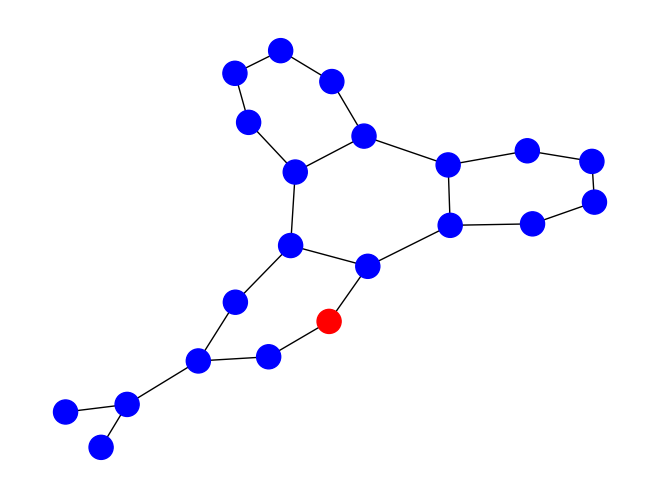

In [69]:
edge_index = adj_mats[-graph].to_sparse().indices().cpu()
x = node_labels[-graph].cpu()
colors = ['r' if n==1.0 else 'b' for n in imp]
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, node_color=colors)